In [1]:
import cv2
import numpy as np

import matplotlib.pyplot as plt

In [8]:


def stitch_images(image1, image2):
    # Convert images to grayscale
    image1_gray = cv2.cvtColor(image1, cv2.COLOR_BGR2GRAY)
    image2_gray = cv2.cvtColor(image2, cv2.COLOR_BGR2GRAY)

    # Initialize the ORB detector and detect keypoints
    orb = cv2.ORB_create()
    keypoints1, descriptors1 = orb.detectAndCompute(image1_gray, None)
    keypoints2, descriptors2 = orb.detectAndCompute(image2_gray, None)

    # Match descriptors
    matcher = cv2.BFMatcher(cv2.NORM_HAMMING, crossCheck=True)
    
    matches = matcher.match(descriptors1, descriptors2)

    # Sort matches by distance
    matches = sorted(matches, key=lambda x: x.distance)
    #matches = matcher.knnMatch(descriptors1, descriptors2,k=2)
   
    # Store all the good matches as per Lowe's ratio test.
    '''
    good = []
    for m, n in matches:
        if m.distance < 0.8 * n.distance:
            good.append(m)
    '''
    # Compute homography
    src_pts = np.float32([keypoints1[m.queryIdx].pt for m in matches]).reshape(-1, 1, 2)
    dst_pts = np.float32([keypoints2[m.trainIdx].pt for m in matches]).reshape(-1, 1, 2)
    img_matches = cv2.drawMatchesKnn(image1,keypoints1,image2,keypoints2,[matches],None,
                          flags=cv2.DrawMatchesFlags_NOT_DRAW_SINGLE_POINTS)
    h1, w1 = img1.shape[:2]
    h2, w2 = img2.shape[:2]
    M, _ = cv2.findHomography(src_pts, dst_pts, cv2.RANSAC,3)
    corners1 = np.float32([[0, 0], [0, h1], [w1, h1], [w1, 0]]).reshape(-1, 1, 2)
    corners2 = np.float32([[0, 0], [0, h2], [w2, h2], [w2, 0]]).reshape(-1, 1, 2)
    warped_corners2 = cv2.perspectiveTransform(corners2, M)

    corners = np.concatenate((corners1, warped_corners2), axis=0)
    [xmin, ymin] = np.int32(corners.min(axis=0).ravel() - 0.5)
    [xmax, ymax] = np.int32(corners.max(axis=0).ravel() + 0.5)

    t = [-xmin, -ymin]
    Ht = np.array([[1, 0, t[0]], [0, 1, t[1]], [0, 0, 1]])
    plt.imshow(cv2.cvtColor(img_matches, cv2.COLOR_BGR2RGB))
    plt.show()
    

    t = [-xmin, -ymin]
    Ht = np.array([[1, 0, t[0]], [0, 1, t[1]], [0, 0, 1]])

    warped_img2 = cv2.warpPerspective(img2, Ht @ M, (xmax - xmin, ymax - ymin))
    warped_img2[t[1]:h1 + t[1], t[0]:w1 + t[0]] = img1
    mask = np.where(img1 != 0, 1, 0).astype(np.float32)
    blended_img = img1 * mask + img2 * (1 - mask)
    return blended_img.astype(np.uint8)

    


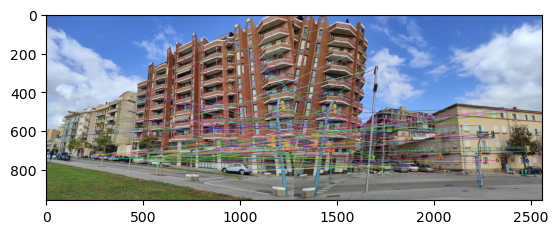

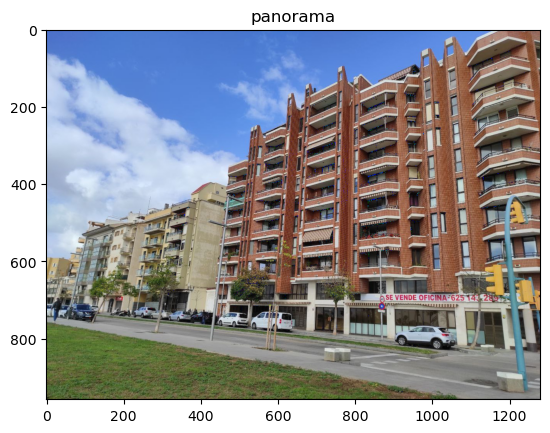

In [9]:
img1 = cv2.imread("sources/train/g1_pt1.jpeg", cv2.COLOR_GRAY2BGR)
img2 = cv2.imread("sources/train/g1_pt2.jpeg", cv2.COLOR_GRAY2BGR)
pan=stitch_images(img1,img2)
plt.imshow(cv2.cvtColor(pan, cv2.COLOR_BGR2RGB))
plt.title('panorama')
plt.show()